<a href="https://colab.research.google.com/github/HowardHNguyen/ML_DL_Time_Series_by_Python/blob/main/Stock_Prediction_Data_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')

In [2]:
from datetime import date

import yfinance as yf
from plotly import graph_objs as go

In [3]:
# Specify the stock symbol and date range
symbol = 'TSLA'
start = '2020-01-02'
end = '2023-12-31'
#end = date.today().strftime("%Y-%m-%d")

In [4]:
# Fetch stock data from Yahoo Finance
df = yf.download(symbol, start=start, end=end)
#df = df.set_index('Date', inplace=True)

[*********************100%%**********************]  1 of 1 completed


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 996 entries, 2020-01-02 to 2023-12-14
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       996 non-null    float64
 1   High       996 non-null    float64
 2   Low        996 non-null    float64
 3   Close      996 non-null    float64
 4   Adj Close  996 non-null    float64
 5   Volume     996 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 54.5 KB


In [6]:
df.head(n=2)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,28.299999,28.713333,28.114,28.684,28.684,142981500
2020-01-03,29.366667,30.266666,29.128,29.534,29.534,266677500


In [7]:
df.index

DatetimeIndex(['2020-01-02', '2020-01-03', '2020-01-06', '2020-01-07',
               '2020-01-08', '2020-01-09', '2020-01-10', '2020-01-13',
               '2020-01-14', '2020-01-15',
               ...
               '2023-12-01', '2023-12-04', '2023-12-05', '2023-12-06',
               '2023-12-07', '2023-12-08', '2023-12-11', '2023-12-12',
               '2023-12-13', '2023-12-14'],
              dtype='datetime64[ns]', name='Date', length=996, freq=None)

In [8]:
df.shape

(996, 6)

In [9]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,996.000000,996.000000,996.000000,996.000000,996.000000,9.960000e+02
mean,208.734479,213.501519,203.595826,208.679156,208.679156,1.334575e+08
std,86.293056,88.010508,84.275724,86.109973,86.109973,8.902998e+07
min,24.980000,26.990667,23.367332,24.081333,24.081333,2.940180e+07
25%,157.937500,160.975002,151.787495,157.452499,157.452499,7.689705e+07
50%,223.291664,227.948334,217.473328,222.664993,222.664993,1.071037e+08
75%,264.289993,268.685005,258.719162,263.835014,263.835014,1.589152e+08
max,411.470001,414.496674,405.666656,409.970001,409.970001,9.140820e+08


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 996 entries, 2020-01-02 to 2023-12-14
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       996 non-null    float64
 1   High       996 non-null    float64
 2   Low        996 non-null    float64
 3   Close      996 non-null    float64
 4   Adj Close  996 non-null    float64
 5   Volume     996 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 54.5 KB


# **EDA**
EDA is an approach to analyzing the data using visual techniques. It is used to discover trends, and patterns, or to check assumptions with the help of statistical summaries and graphical representations.

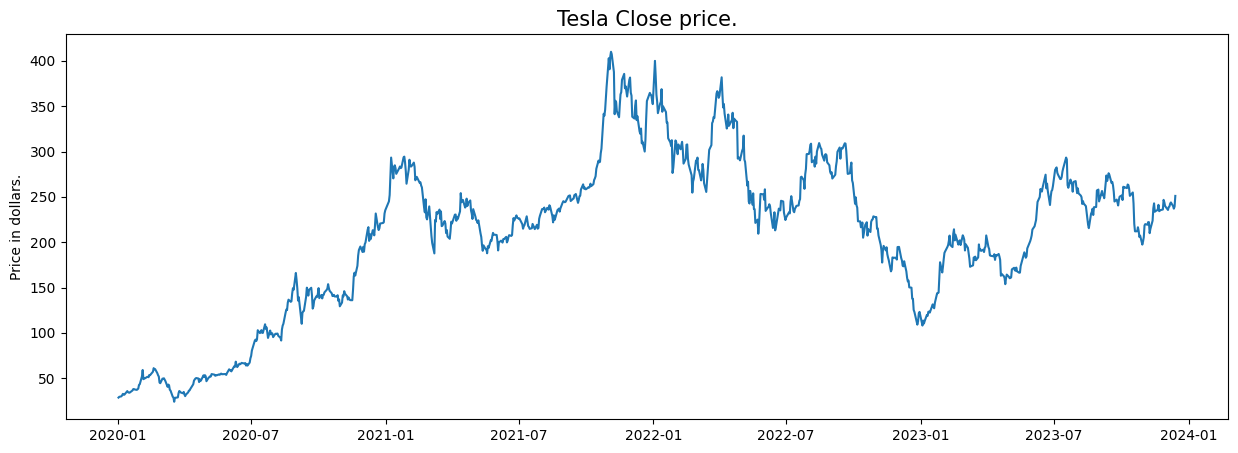

In [11]:
plt.figure(figsize=(15,5))
plt.plot(df['Close'])
plt.title('Tesla Close price.', fontsize=15)
plt.ylabel('Price in dollars.')
plt.show()

If we observe carefully we can see that the data in the ‘Close’ column and that available in the ‘Adj Close’ column is the same let’s check whether this is the case with each row or not.

In [12]:
df[df['Close'] == df['Adj Close']].shape

(996, 6)

From here we can conclude that all the rows of columns ‘Close’ and ‘Adj Close’ have the same data. So, having redundant data in the dataset is not going to help so, we’ll drop this column before further analysis.

In [13]:
df = df.drop(['Adj Close'], axis=1)

Now let’s draw the distribution plot for the continuous features given in the dataset.

Before moving further let’s check for the null values if any are present in the data frame.

In [14]:
df.isnull().sum()

Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

In [15]:
columns = ['Open', 'High', 'Low', 'Close', 'Volume']

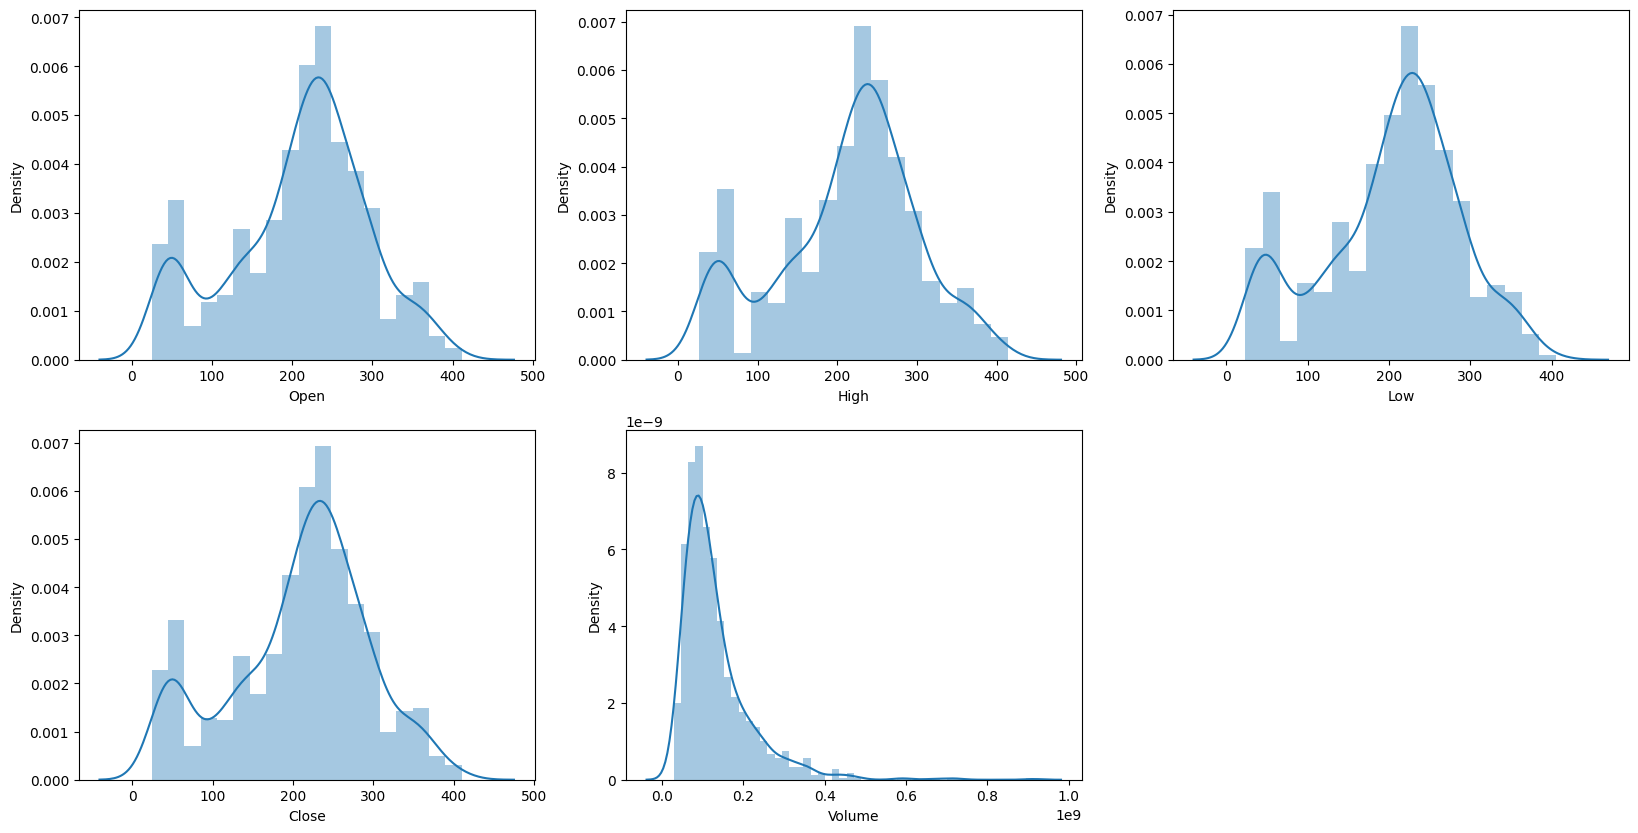

In [16]:
plt.subplots(figsize=(20, 10))
for i in columns:
    plt.subplot(2, 3, columns.index(i)+1)
    sb.distplot(df[i])

In the distribution plot of OHLC data, we can see two peaks which means the data has varied significantly in two regions. And the Volume data is left-skewed.

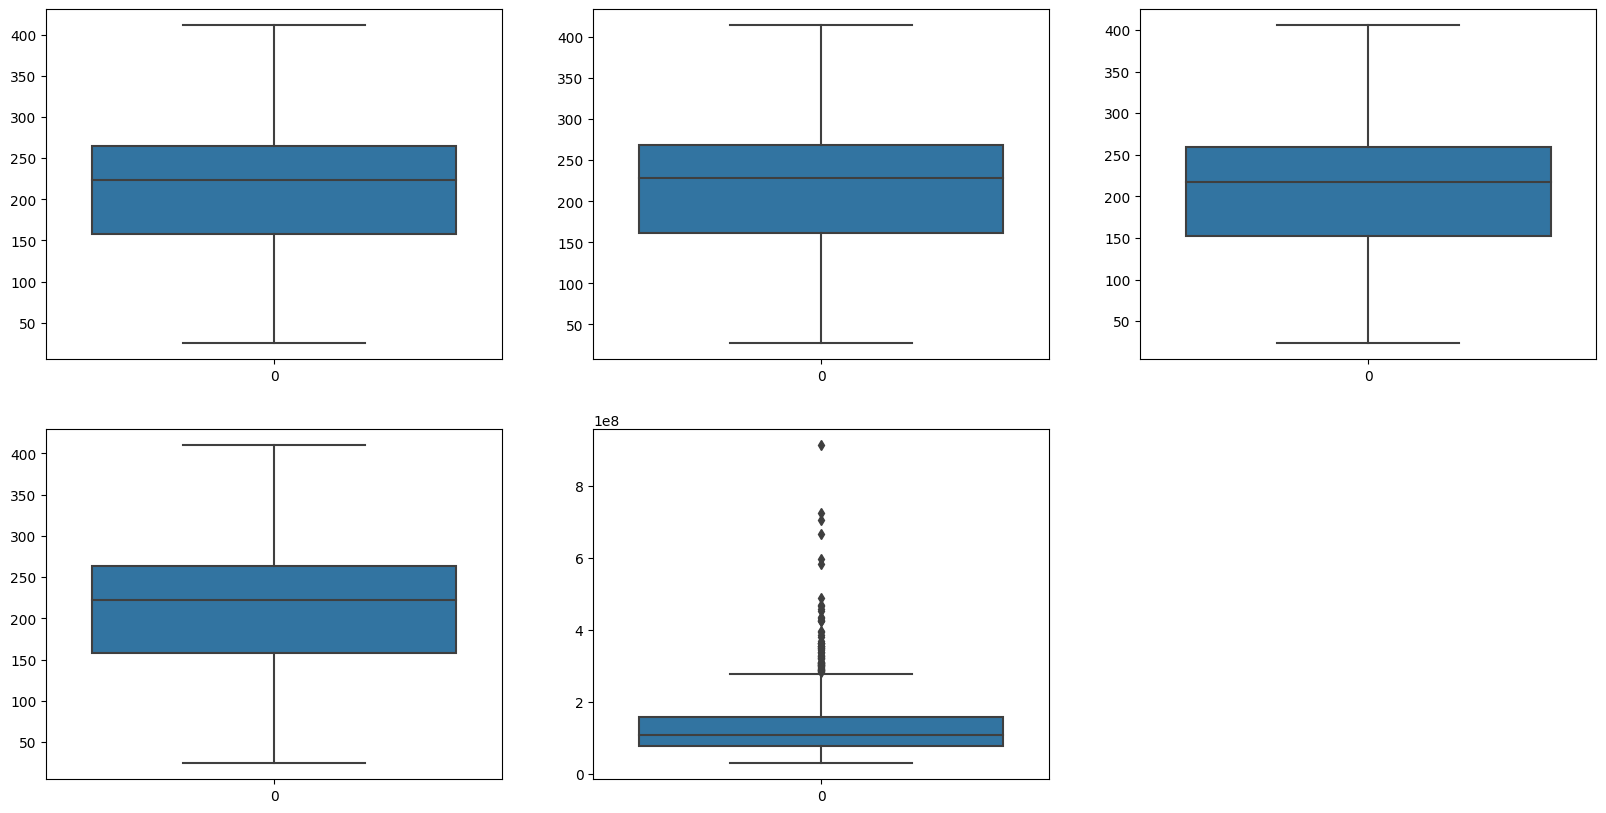

In [17]:
plt.subplots(figsize=(20, 10))
for i in columns:
    plt.subplot(2, 3, columns.index(i)+1)
    sb.boxplot(df[i])

From the above boxplots, we can consolude that only 'volume' data contains outliers in it but the data in the rest of the columns are free from any outliers.

# **Feature Engineering**
Feature Engineering helps to derive some valuable features from the existing ones. These extra features sometimes help in increasing the performance of the model significantly and certainly help to gain deeper insights into the data.

In [18]:
df.head(n=2)

,Open,High,Low,Close,Volume
Date,,,,,
2020-01-02,28.299999,28.713333,28.114,28.684,142981500
2020-01-03,29.366667,30.266666,29.128,29.534,266677500


In [19]:
print(df.index.dtype)

datetime64[ns]


In [20]:
print(df.columns)

Index(['Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')


# Convert Date into Index column

In [21]:
df.reset_index(inplace=True)

df['Date'] = df['Date'].dt.strftime('%Y/%m/%d')

In [22]:
df.head(n=2)

,Date,Open,High,Low,Close,Volume
0,2020/01/02,28.299999,28.713333,28.114,28.684,142981500
1,2020/01/03,29.366667,30.266666,29.128,29.534,266677500


In [23]:
splitted = df['Date'].str.split('/', expand=True)
df['day'] = splitted[2].astype('int')
df['month'] = splitted[1].astype('int')
df['year'] = splitted[0].astype('int')

In [24]:
df.head(n=2)

,Date,Open,High,Low,Close,Volume,day,month,year
0,2020/01/02,28.299999,28.713333,28.114,28.684,142981500,2,1,2020
1,2020/01/03,29.366667,30.266666,29.128,29.534,266677500,3,1,2020


Now we have three more columns namely ‘day’, ‘month’ and ‘year’ all these three have been derived from the ‘Date’ column which was initially provided in the data.

In [25]:
df['is_quarter_end'] = np.where(df['month']%3==0,1,0)
df.head()

,Date,Open,High,Low,Close,Volume,day,month,year,is_quarter_end
0,2020/01/02,28.299999,28.713333,28.114000,28.684000,142981500,2,1,2020,0
1,2020/01/03,29.366667,30.266666,29.128000,29.534000,266677500,3,1,2020,0
2,2020/01/06,29.364668,30.104000,29.333332,30.102667,151995000,6,1,2020,0
3,2020/01/07,30.760000,31.441999,30.224001,31.270666,268231500,7,1,2020,0
4,2020/01/08,31.580000,33.232666,31.215334,32.809334,467164500,8,1,2020,0


A quarter is defined as a group of three months. Every company prepares its quarterly results and publishes them publicly so, that people can analyze the company’s performance. These quarterly results affect the stock prices heavily which is why we have added this feature because this can be a helpful feature for the learning model.

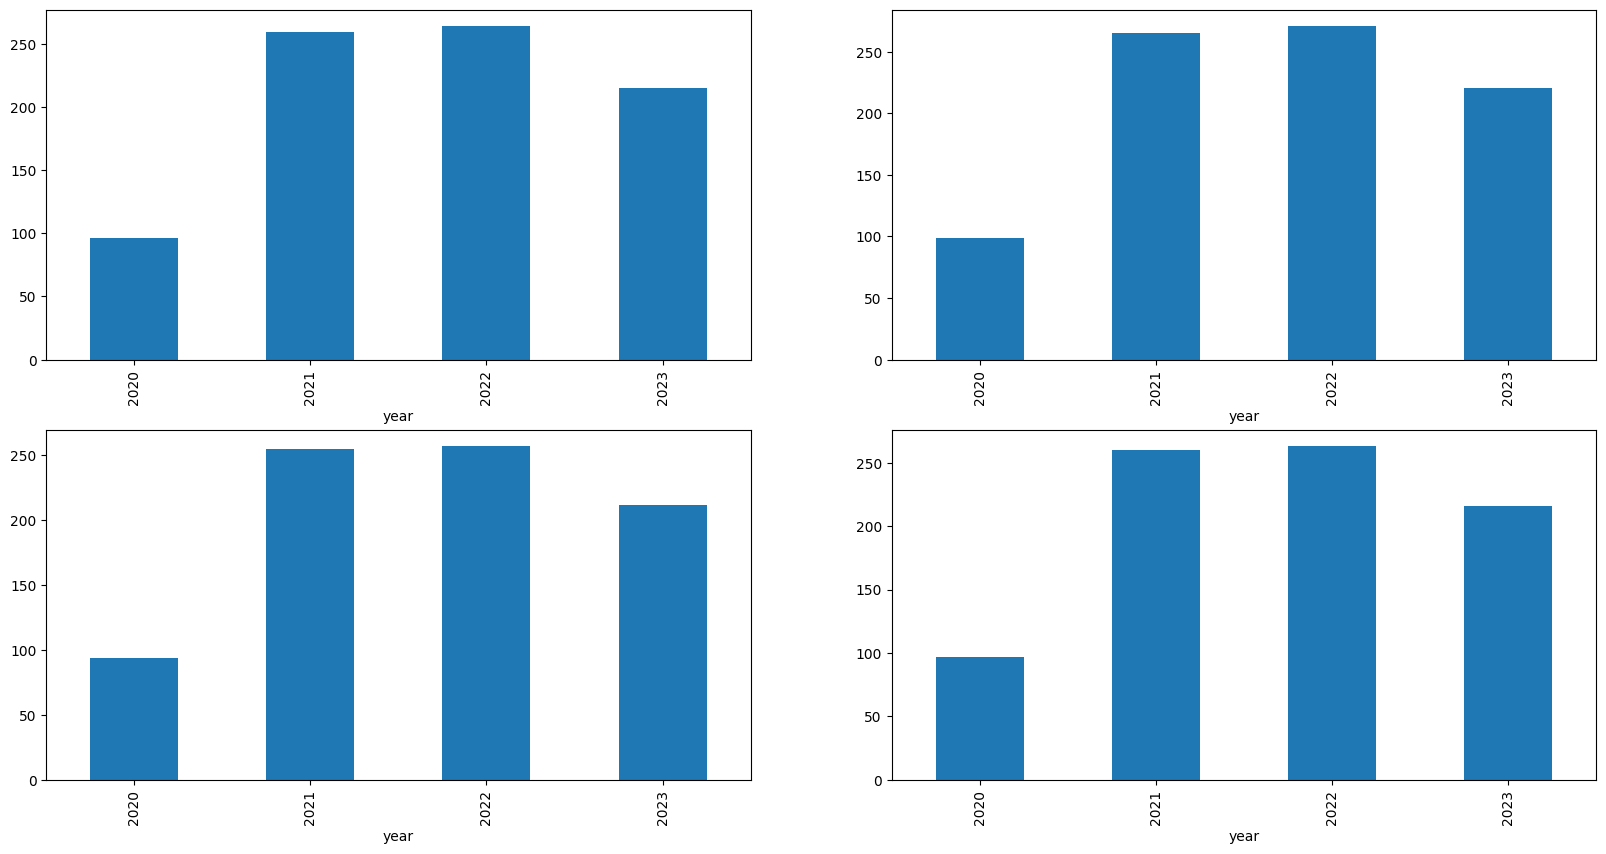

In [26]:
data_grouped = df.groupby('year').mean()
plt.subplots(figsize=(20,10))

for i, col in enumerate(['Open', 'High', 'Low', 'Close']):
  plt.subplot(2,2,i+1)
  data_grouped[col].plot.bar()
plt.show()

In [27]:
df.groupby('is_quarter_end').mean()

,Open,High,Low,Close,Volume,day,month,year
is_quarter_end,,,,,,,,
0,208.014865,212.753739,202.852173,207.866448,1.339063e+08,15.706505,6.107413,2021.500756
1,210.154372,214.976989,205.063152,210.282738,1.325720e+08,15.602985,7.271642,2021.438806


**Here are some of the important observations of the above-grouped data:**

Prices are higher in the months which are quarter end as compared to that of the non-quarter end months.
The volume of trades is lower in the months which are quarter end.

In [28]:
df['open-close']  = df['Open'] - df['Close']
df['low-high']  = df['Low'] - df['High']
df['target'] = np.where(df['Close'].shift(-1) > df['Close'], 1, 0)

Above we have added some more columns which will help in the training of our model. We have added the target feature which is a signal whether to buy or not we will train our model to predict this only. But before proceeding let’s check whether the target is balanced or not using a pie chart.

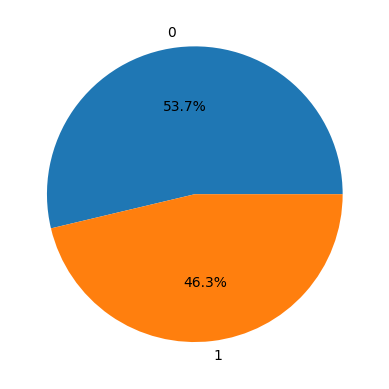

In [29]:
plt.pie(df['target'].value_counts().values,
        labels=[0, 1], autopct='%1.1f%%')
plt.show()

When we add features to our dataset we have to ensure that there are no highly correlated features as they do not help in the learning process of the algorithm.

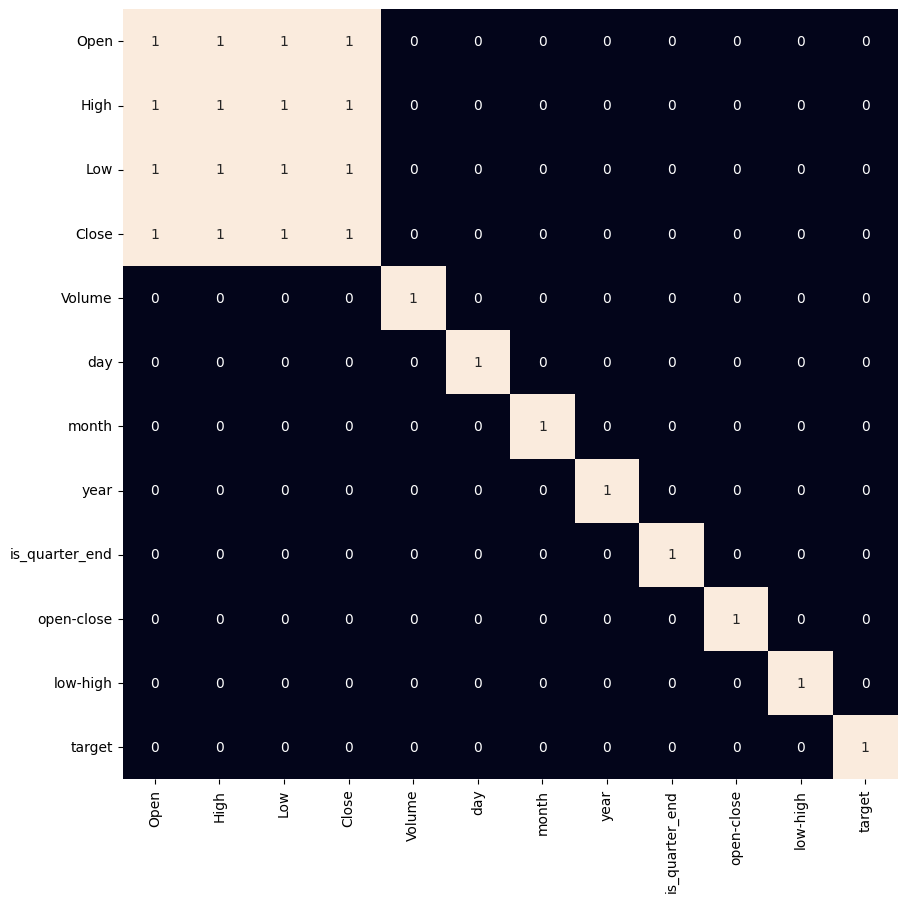

In [30]:
plt.figure(figsize=(10, 10))

# As our concern is with the highly
# correlated features only so, we will visualize
# our heatmap as per that criteria only.
sb.heatmap(df.corr() > 0.9, annot=True, cbar=False)
plt.show()

From the above heatmap, we can say that there is a high correlation between OHLC that is pretty obvious, and the added features are not highly correlated with each other or previously provided features which means that we are good to go and build our model.

# **Data Splitting and Normalization**

In [31]:
features = df[['open-close', 'low-high', 'is_quarter_end']]
target = df['target']

scaler = StandardScaler()
features = scaler.fit_transform(features)

X_train, X_valid, Y_train, Y_valid = train_test_split(
    features, target, test_size=0.1, random_state=2022)
print(X_train.shape, X_valid.shape)

(896, 3) (100, 3)


After selecting the features to train the model on we should normalize the data because normalized data leads to stable and fast training of the model. After that whole data has been split into two parts with a 90/10 ratio so, that we can evaluate the performance of our model on unseen data.

# **Model Development and Evaluation**
Now is the time to train some state-of-the-art machine learning models(Logistic Regression, Support Vector Machine, XGBClassifier), and then based on their performance on the training and validation data we will choose which ML model is serving the purpose at hand better.

For the evaluation metric, we will use the ROC-AUC curve but why this is because instead of predicting the hard probability that is 0 or 1 we would like it to predict soft probabilities that are continuous values between 0 to 1. And with soft probabilities, the ROC-AUC curve is generally used to measure the accuracy of the predictions.

In [32]:
models = [LogisticRegression(), SVC(
  kernel='poly', probability=True), XGBClassifier()]

for i in range(3):
  models[i].fit(X_train, Y_train)

  print(f'{models[i]} : ')
  print('Training Accuracy : ', metrics.roc_auc_score(
    Y_train, models[i].predict_proba(X_train)[:,1]))
  print('Validation Accuracy : ', metrics.roc_auc_score(
    Y_valid, models[i].predict_proba(X_valid)[:,1]))
  print()

LogisticRegression() : 
Training Accuracy :  0.5278424135440904
Validation Accuracy :  0.5146058423369347

SVC(kernel='poly', probability=True) : 
Training Accuracy :  0.4708888309395812
Validation Accuracy :  0.4645858343337335

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...) : 
Training 

Among the three models, we have trained XGBClassifier has the highest performance but it is pruned to overfitting as the difference between the training and the validation accuracy is too high. But in the case of the Logistic Regression, this is not the case.

Now let’s plot a confusion matrix for the validation data.

In [56]:
!pip install --upgrade scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 31.1 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


In [33]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn import metrics

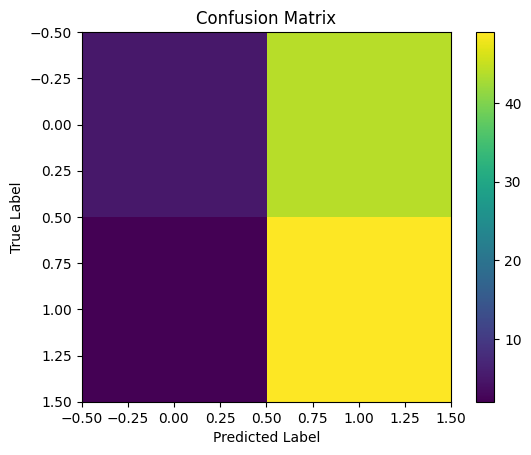

In [34]:
# Compute the confusion matrix
y_pred = models[0].predict(X_valid)
cm = confusion_matrix(Y_valid, y_pred)

# Plot the confusion matrix
plt.imshow(cm, interpolation='nearest')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# **Conclusion:**
We can observe that the accuracy achieved by the state-of-the-art ML model is no better than simply guessing with a probability of 50%. Possible reasons for this may be the lack of data or using a very simple model to perform such a complex task as Stock Market prediction.